In [1]:
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import pydpf
import torch
from data_prep import prepare_data
import model
import neural_networks
import training

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda_gen = torch.Generator(device=device).manual_seed(2)

## Prepare data

In [2]:
#prepare_data('cuda:0')

In [3]:
observation_encoding_size = 32

In [4]:
def flatten_gens(list_of_gens):
    return [item for gen in list_of_gens for item in gen]
    
def is_in_it(item, it):
    return any(id(item) == id(item_) for item_ in it)
    

def get_SSM():
    encoder = neural_networks.ObservationEncoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    decoder = neural_networks.ObservationDecoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    state_encoder = neural_networks.StateEncoder(observation_encoding_size, generator=cuda_gen, dropout_keep_ratio=0.3)
    observation_partial_flows = [neural_networks.RealNVP_cond(dim = observation_encoding_size, hidden_dim=8, condition_on_dim=32, generator = cuda_gen), neural_networks.RealNVP_cond(dim = 32, hidden_dim=8, condition_on_dim=32, generator = cuda_gen)]
    observation_flow = neural_networks.NormalizingFlowModel_cond(pydpf.StandardGaussian(32, cuda_gen), observation_partial_flows, device)
    observation_model = model.MazeObservation(observation_flow, encoder, decoder, state_encoder)
    #observation_model = model.SimpleMazeObservation(encoder, decoder, state_encoder)
    dynamic_cov = torch.nn.Parameter(torch.diag(torch.rand(3, device=device, generator=cuda_gen)/100), requires_grad=True)
    #dynamic_cov = torch.diag(torch.tensor([0.001, 0.001, 0.003], device=device))
    dynamic_model = model.MazeDynamic(cuda_gen, dynamic_cov)
    proposal_partial_flows = [neural_networks.RealNVP_cond(dim = 3, hidden_dim=8, condition_on_dim=32, generator=cuda_gen, zero_i=True), neural_networks.RealNVP_cond(dim = 3, hidden_dim=8, condition_on_dim=32, generator=cuda_gen, zero_i=True)]
    proposal_flow = neural_networks.NormalizingFlowModel_cond(None, proposal_partial_flows, device)
    proposal_model = model.MazeProposal(proposal_flow, dynamic_model)
    prior_model = model.MazePrior(2., 2., cuda_gen)
    #prior_model = model.MazePriorCheat()
    encoder_parameters = flatten_gens([encoder.parameters(), state_encoder.parameters(), decoder.parameters()])
    flow_parameters = flatten_gens([observation_flow.parameters(), proposal_flow.parameters(), prior_model.parameters()])
    SSM = pydpf.FilteringModel(dynamic_model=dynamic_model, proposal_model=proposal_model, prior_model=prior_model, observation_model=observation_model)
    #SSM = pydpf.FilteringModel(dynamic_model=dynamic_model, prior_model=prior_model, observation_model=observation_model)
    return SSM, encoder_parameters, flow_parameters, [dynamic_cov]
            

In [5]:
def transform_control(control, state, **data):
    angles = torch.roll(state[:, :, 2], 1, 0)
    c = torch.cos(angles)
    s = torch.sin(angles)
    diff = (1/650) - (1/1000)
    transformation_matrix = torch.stack([torch.stack([1/1000 + diff*(s**2), c*s*diff], dim=-1), torch.stack([c*s*diff, 1/1000 + diff*(c**2)], dim=-1)], dim=-2)
    output = torch.cat([torch.einsum('tbij, tbj -> tbi', transformation_matrix, control[:, :, :2]), control[:,:,2:3]], dim=-1)
    output[0,:,:] = state[0,:,:]
    return output
    

In [6]:
def normalise_obs(observation, **data):
    return (observation - torch.mean(observation))/torch.std(observation)
    

In [7]:
SSM, encoder_params, flow_params, dynamic_params = get_SSM()
dpf = pydpf.DPF(SSM=SSM, resampling_generator=cuda_gen)
#dpf = pydpf.OptimalTransportDPF(SSM=SSM, regularisation=0.1, step_size=0.75)
dpf.to(device)
if dynamic_params[0].requires_grad:
    opt = torch.optim.Adam([{'params': encoder_params, 'lr': 0.001}, {'params': flow_params, 'lr': 0.0001}, {'params':dynamic_params, 'lr': 0.001}])
else:
    opt = torch.optim.Adam([{'params': encoder_params, 'lr': 1.}, {'params': flow_params, 'lr': 1.}])
data = pydpf.StateSpaceDataset(data_path= pathlib.Path('.').parent.absolute().joinpath('data/maze_data.csv'), state_prefix='state', control_prefix='control', device = device)
data.apply(normalise_obs,  'observation')
scaling_tesnor = torch.tensor([[[1000., 650., 1.]]], device=device)
data.apply(lambda state, **data: state/scaling_tesnor - torch.tensor([[[1., 1., 0.]]], device=device), 'state')
data.apply(transform_control, 'control')
#test_control(data.control, data.state)
training.train(dpf, opt, data, 10, (100, 100, 100), (128, 128, 128), (0.45, 0.2, 0.35), (10., 0.05, 10.), torch.Generator().manual_seed(0), None, 'MSE', 99, pre_train_epochs=0, device=device)


1034.2684326171875
1183.98681640625
927.28125
917.3113403320312
759.34326171875
847.8750610351562
793.2568969726562
611.366455078125
epoch 1/10, train loss: 9.967203754848905, validation position RMSE: 853.4306943155958, validation angle RMSE: 1.7658514124094977
902.1410522460938
970.4389038085938
882.9266967773438
838.5336303710938
851.7346801757812
780.8005981445312
785.5460815429688
347.9537353515625
epoch 2/10, train loss: 8.524103745354546, validation position RMSE: 881.9752207403562, validation angle RMSE: 1.7369500476811786
737.7880249023438
845.4292602539062
804.1275024414062
724.9276733398438
784.0846557617188
747.843994140625
711.8251953125
788.1636352539062
epoch 3/10, train loss: 7.429614774915907, validation position RMSE: 914.1061645126347, validation angle RMSE: 1.6953121540403233
770.517333984375
687.9033813476562
724.591796875
773.6635131835938
673.9030151367188
712.718017578125
637.3154907226562
777.4547119140625
epoch 4/10, train loss: 7.005585619608561, validation p

KeyboardInterrupt: 

Parameter containing:
tensor([[0.0066, 0.0000, 0.0000],
        [0.0000, 0.0095, 0.0000],
        [0.0000, 0.0000, 0.0133]], device='cuda:0', requires_grad=True)
(100, 1, 1000, 3)


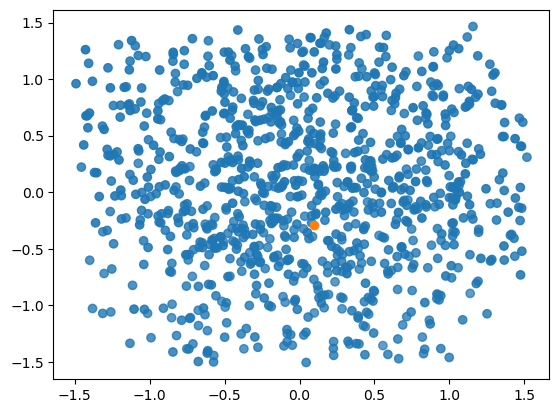

In [8]:
obs = data.observation[:, 0:1]
state = data.state[:, 0:1]
control = data.control[:, 0:1]
print(dynamic_params[0])
time = 5
batch = 0
encoded_obs = SSM.observation_model.encoder(obs.reshape(obs.size(0)*obs.size(1), 3, 24, 24))
dpf.update()
with torch.inference_mode():
    ps = dpf(1000, 99, {'state': pydpf.State(), 'weight': pydpf.Weight()}, observation=encoded_obs.reshape(100, 1, encoded_obs.size(1)).contiguous(), ground_truth=state, control=control)
numpy_ps = ps['state'].detach().cpu().numpy()
numpy_weight = ps['weight'].detach().cpu().numpy()
#print(numpy_weight[0, 0, :])
plt.scatter(numpy_ps[time,batch,:,0], numpy_ps[time,batch,:,1], alpha=np.exp(numpy_weight[time, batch, :])/np.max(np.exp(numpy_weight[time, batch, :])))
plt.scatter(state.cpu().numpy()[time,batch,0], state.cpu().numpy()[time,batch,1])
print(numpy_ps.shape)
#plt.xlim(-1, 1)
#plt.ylim(-1, 1)
plt.show()